<center>
<h2>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h2>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2020</h3>
<h3>Predicción de la Calidad de Servicio</h3>
<h3>Análisis y Curación</h3>
</center>
</left>
<h4>Mentor: Martín Hunziker</h4>

[Link Mentoria](https://sites.google.com/view/mentorias2020-diplodatos/ciencia-de-datos-aplicada-en-la-distribuci%C3%B3n-de-energ%C3%ADa-el%C3%A9ctrica?authuser=0).

</left>
</left>

#Grupo 2
###Marcelo Tisera
###Laura Aliendo
###Joel de Andres

### Introducción

En la siguiente notebook, se presentará la consigna a seguir para el segundo práctico de la materia Análisis y Curación. El objetivo consiste en vincular las tablas del dataset, así como iniciar el tratamiento de los datos geográficos.

Como referencia para el análisis geográfico utilizaremos la notebook 2_0_Intro_Variables_georefrenciadas de Ramiro Caro.


### I. Rutina de Curación

Inicialmente, con el objetivo de preparar los datos que alimentarán futuros modelos de aprendizaje automático (ML), se propone seguir la siguiente __[checklist](https://dimewiki.worldbank.org/wiki/Checklist:_Data_Cleaning)__ para la limpieza de los datos de nuestro proyecto. Esta _checklist_ es la misma que utilizaron en el primer práctico de la materia y nos será de utilidad como guía para curar el dataset. A modo de ayuda, **en esta notebook encontrarán una especie de template** que sigue la _checklist_ y que deberán ir completando.

**Cada decisión tomada deberá quedar registrada de manera explícita y clara.** Luego de pasar por todos los puntos de la _checklist_ propuesta, deberán almacenar en un nuevo archivo los datos resultantes.


### II. Análisis del Contenido

Una vez aplicado el  _Checklist_, lo que vamos a hacer es comenzar a vincular las diferentes tablas del dataset e iniciar la generación de features geográficas


# Resolución

## I. Rutina de Curación

### 1. Importación de Datos

#### 1.1. Verificación de Inexistencia de Problemas en la Importación

A partir de este punto, utilizaremos los transformadores de distribucion como elemnto de analisis tabla UNTRD, e incorporaremos datos de consumidores, subestación y líneas de distribución.

Para comenzar, importamos los datos que vamos a procesar de las diferentes tablas que vamos a analizar:

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString
import numpy as np
import osmnx as ox
import scipy as sc
from sklearn import preprocessing
from shapely.ops import nearest_points
from scipy.spatial import cKDTree

import WazeRouteCalculator
from itertools import tee
import time

In [2]:
# Editar con el path correspondiente a sus datos
data_path = './Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb'
data_path_origin = './Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb'

print(data_path)
print(data_path_origin)
 

./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb
./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb


In [3]:
datasets = {}

In [4]:
conj = gpd.read_file(data_path, driver='FileGDB', layer='CONJ')
datasets['conj'] = conj
datasets['conj']['COD_ID'] = datasets['conj']['COD_ID'].astype(int)
conj = datasets['conj']
conj.shape, conj.columns 

((5, 9),
 Index(['COD_ID', 'DIST', 'NOM', 'SIST_INTE', 'SIST_SUBT', 'DESCR',
        'Shape_Length', 'Shape_Area', 'geometry'],
       dtype='object'))

In [5]:
untrd = gpd.read_file(data_path, driver='FileGDB', layer='UNTRD')
untrd['CONJ'] = untrd['CONJ'].astype(int)
untrd.shape, untrd.columns

((3879, 33),
 Index(['COD_ID', 'DIST', 'PAC_1', 'PAC_2', 'PAC_3', 'FAS_CON_P', 'FAS_CON_S',
        'FAS_CON_T', 'SIT_ATIV', 'TIP_UNID', 'POS', 'ATRB_PER', 'TEN_LIN_SE',
        'CAP_ELO', 'CAP_CHA', 'TAP', 'CONF', 'POSTO', 'POT_NOM', 'PER_FER',
        'PER_TOT', 'DAT_CON', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ', 'MUN', 'BANC',
        'TIP_TRAFO', 'MRT', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [6]:
untrs = gpd.read_file(data_path, driver='FileGDB', layer='UNTRS')
untrs['CONJ'] = untrs['CONJ'].astype(int)
untrs.shape, untrs.columns

((6, 53),
 Index(['COD_ID', 'SUB', 'BARR_1', 'BARR_2', 'BARR_3', 'PAC_1', 'PAC_2',
        'PAC_3', 'DIST', 'FAS_CON_P', 'FAS_CON_S', 'FAS_CON_T', 'SIT_ATIV',
        'TIP_UNID', 'POS', 'POT_NOM', 'POT_F01', 'POT_F02', 'PER_FER',
        'PER_TOT', 'BANC', 'DAT_CON', 'CONJ', 'MUN', 'TIP_TRAFO', 'ALOC_PERD',
        'ENES_01', 'ENES_02', 'ENES_03', 'ENES_04', 'ENES_05', 'ENES_06',
        'ENES_07', 'ENES_08', 'ENES_09', 'ENES_10', 'ENES_11', 'ENES_12',
        'ENET_01', 'ENET_02', 'ENET_03', 'ENET_04', 'ENET_05', 'ENET_06',
        'ENET_07', 'ENET_08', 'ENET_09', 'ENET_10', 'ENET_11', 'ENET_12',
        'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [7]:
ssmt = gpd.read_file(data_path, driver='FileGDB', layer='SSDMT')
ssmt['CONJ'] = ssmt['CONJ'].astype(int)
ssmt.shape, ssmt.columns

((24929, 24),
 Index(['COD_ID', 'PN_CON_1', 'PN_CON_2', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
        'DIST', 'PAC_1', 'PAC_2', 'FAS_CON', 'TIP_CND', 'POS', 'ODI_FAS',
        'TI_FAS', 'ODI_NEU', 'TI_NEU', 'COMP', 'DESCR', 'SITCONTFAS',
        'SITCONTNEU', 'ARE_LOC', 'Shape_Length', 'geometry'],
       dtype='object'))

In [8]:
segcon = gpd.read_file(data_path, driver='FileGDB', layer='SEGCON')
segcon.shape, segcon.columns

((90, 40),
 Index(['COD_ID', 'DIST', 'GEOM_CAB', 'FORM_CAB', 'MAT_FAS_1', 'MAT_FAS_2',
        'MAT_FAS_3', 'MAT_NEU', 'ISO_FAS_1', 'ISO_FAS_2', 'ISO_FAS_3',
        'ISO_NEU', 'CND_FAS', 'R1', 'X1', 'FTRCNV', 'CNOM', 'CMAX', 'CM_FAS',
        'TUC_FAS', 'A1_FAS', 'A2_FAS', 'A3_FAS', 'A4_FAS', 'A5_FAS', 'A6_FAS',
        'CM_NEU', 'TUC_NEU', 'A1_NEU', 'A2_NEU', 'A3_NEU', 'A4_NEU', 'A5_NEU',
        'A6_NEU', 'DESCR', 'BIT_FAS_1', 'BIT_FAS_2', 'BIT_FAS_3', 'BIT_NEU',
        'geometry'],
       dtype='object'))

In [9]:
ucbt = gpd.read_file(data_path, driver='FileGDB', layer='UCBT')
ucbt['CONJ'] = ucbt['CONJ'].astype(int)
ucbt.shape, ucbt.columns

((108346, 40),
 Index(['DIST', 'PAC', 'PN_CON', 'UNI_TR_D', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
        'MUN', 'BRR', 'CEP', 'CLAS_SUB', 'CNAE', 'TIP_CC', 'FAS_CON', 'GRU_TEN',
        'TEN_FORN', 'GRU_TAR', 'SIT_ATIV', 'DAT_CON', 'CAR_INST', 'LIV',
        'ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07',
        'ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12', 'DIC', 'FIC',
        'SEMRED', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [10]:
# Agrupando Variables

ucbt['ENE_MED'] = ucbt[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].mean(axis=1)
ucbt['ENE_STD'] = ucbt[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].std(axis=1)
ucbt['ENE_MAX'] = ucbt[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].max(axis=1)


### 1.2. Asegurar la Existencia de IDs o Claves Únicas

In [11]:
print(untrd['COD_ID'].is_unique)
print(untrs['COD_ID'].is_unique)
print(ssmt['COD_ID'].is_unique)
print(segcon['COD_ID'].is_unique)

True
True
True
True


El siguiente paso implica chequear que no existen datos duplicados y que las claves, si existen, son únicas.

Las claves únicas de las diferentes tablas es el COD_ID, como figura en la documentación. En el caso de la tabla UCBT fue eliminado por el proveedor de los datos por lo que asumiremos que los datos son únicos. Podriamos regenerar el COD_ID con un valor secuencial, pero como vamos a utilizar la tabla UNTRD como elementos de análisis no será necesario

In [12]:
cod_id = 'COD_ID'
untrd_duplicado_cod_id  = untrd[untrd[cod_id].duplicated(keep=False)]
untrd_duplicado_cod_id

,COD_ID,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,...,UNI_TR_S,SUB,CONJ,MUN,BANC,TIP_TRAFO,MRT,DESCR,ARE_LOC,geometry


In [13]:
untrs_duplicado_cod_id  = untrs[untrs[cod_id].duplicated(keep=False)]
untrs_duplicado_cod_id

,COD_ID,SUB,BARR_1,BARR_2,BARR_3,PAC_1,PAC_2,PAC_3,DIST,FAS_CON_P,...,ENET_06,ENET_07,ENET_08,ENET_09,ENET_10,ENET_11,ENET_12,DESCR,ARE_LOC,geometry


In [14]:
ssmt_duplicado_cod_id  = ssmt[ssmt[cod_id].duplicated(keep=False)]
ssmt_duplicado_cod_id

,COD_ID,PN_CON_1,PN_CON_2,CTMT,UNI_TR_S,SUB,CONJ,DIST,PAC_1,PAC_2,...,TI_FAS,ODI_NEU,TI_NEU,COMP,DESCR,SITCONTFAS,SITCONTNEU,ARE_LOC,Shape_Length,geometry


In [15]:
segcon_duplicado_cod_id  = segcon[segcon[cod_id].duplicated(keep=False)]
segcon_duplicado_cod_id

,COD_ID,DIST,GEOM_CAB,FORM_CAB,MAT_FAS_1,MAT_FAS_2,MAT_FAS_3,MAT_NEU,ISO_FAS_1,ISO_FAS_2,...,A3_NEU,A4_NEU,A5_NEU,A6_NEU,DESCR,BIT_FAS_1,BIT_FAS_2,BIT_FAS_3,BIT_NEU,geometry


In [16]:
conj_duplicado_cod_id  = conj[conj[cod_id].duplicated(keep=False)]
conj_duplicado_cod_id

,COD_ID,DIST,NOM,SIST_INTE,SIST_SUBT,DESCR,Shape_Length,Shape_Area,geometry


### 1.3. Despersonalizar Datos y Guardarlos en un Nuevo Archivo

En este caso, no es necesario despersonalizar ningún dato, dado que los mismos ya se encuentran despersonalizados.

### 1.4. Nunca Modificar los Datos Crudos u Originales

Al finalizar la limpieza, deberán guardar el dataset resultante, para asegurarse de no modificar los datos originales.

Creamos 2 dataset para evitar modificar el original 1 con el nombre de que esta en un dir DatasetOrigin/data_path_origin.

El que usaremos para modificar que es el data_path en el dir Dataset/

## 2. Pasos de Limpieza Necesarios

### 2.1. Etiquetas de Variables/Columnas y Problemas de Codificación/Encoding

El geopandas automáticamente detecta el encoding de los datos. 

### 2.2. Tratamiento de Valores Faltantes

Para analizar los valores faltantes, primero deberán saber cuántos existen por campo y cuánto representan del total:

In [17]:
# get the number of missing data points per column
list_dataset = [{"name":"UNTRD","data_set":untrd},
{"name":"UNTRS","data_set":untrs},
{"name":"SSMT","data_set":ssmt}, 
{"name":"SEGCON","data_set":segcon}, 
{"name":"CONJ","data_set":conj}]

for dataset in list_dataset:
  missing_value = dataset.get("data_set").isnull().sum()
  count_value = dataset.get("data_set").COD_ID.count()
  print("\nValores null de {} : {}".format(dataset.get("name"),missing_value[missing_value > 0]))
  if len( missing_value[missing_value > 0]) > 0 :
    for i in missing_value[missing_value > 0]:
      print("Cantidad de registros  : {}".format(count_value))
      print("Cantidad de registros Null : {}".format(i))
      print("Representa el % : {}".format((i*100)/count_value))
  else:
    print("No tiene valores Nulls")




Valores null de UNTRD : Series([], dtype: int64)
No tiene valores Nulls

Valores null de UNTRS : Series([], dtype: int64)
No tiene valores Nulls

Valores null de SSMT : Series([], dtype: int64)
No tiene valores Nulls

Valores null de SEGCON : geometry    90
dtype: int64
Cantidad de registros  : 90
Cantidad de registros Null : 90
Representa el % : 100.0

Valores null de CONJ : Series([], dtype: int64)
No tiene valores Nulls


En la tabla de SEGCON existen valores null en el campo geometry en la totalidad de los registros.

### 2.3. Codificación de Variables Categóricas

Aplica?

In [18]:
datasets = {'untrd': untrd, 'ucbt': ucbt}
columns_to_encode = ['ARE_LOC', 'GRU_TAR']

for key, dataset in datasets.items():
    for column in columns_to_encode:
        if column in dataset:
            le = preprocessing.LabelEncoder()
            le.fit(dataset[column])
            dataset[column] = le.transform(dataset[column])

### 2.4. No Cambiar los Nombres de las Variables de la Fuente de Origen

No aplica.

### 2.5. Verificación de Consistencia de Datos

Este es el paso más analítico, en donde se deben aplicar reglas de integridad.

Si se eliminana lo valores NaN que pasa con los registros de segcon? 

In [19]:
untrd = untrd.dropna()
untrs = untrs.dropna()
ssmt = ssmt.dropna()
#segcon = segcon.dropna()
ucbt = ucbt.dropna()
conj = conj.dropna()

### 2.6. Identificar y Documentar Valores Atípicos/Outliers

Calcular estadísticos.

In [20]:
def find_outliers(dataset, column_name):
    interesting_col = dataset[column_name]
    CI =  (interesting_col.quantile(0.75)-interesting_col.quantile(0.25))
    mask_outlier = (
        np.abs(interesting_col - interesting_col.median()) >= (1.5 * CI))
    return dataset[mask_outlier]


main_statisticians = ['FIC', 'DIC', 'ENE_MED']

outliers = []
for key, dataset in datasets.items():
    print("Dataset: ", key)
    for column in main_statisticians:
        if column in dataset:
            outliers = find_outliers(dataset, column)
            row_quantity = dataset.shape[0]
            print("Cantidad de outliers para la variable ", column, len(outliers))
    print("------------------------------------------------")

Dataset:  untrd
------------------------------------------------
Dataset:  ucbt
Cantidad de outliers para la variable  FIC 12360
Cantidad de outliers para la variable  DIC 15122
Cantidad de outliers para la variable  ENE_MED 8363
------------------------------------------------


In [21]:
# Procedemos a limpiar los outliers para la layer ucbt
def clean_outliers(dataset, column_name):
    interesting_col = dataset[column_name]
    CI =  (interesting_col.quantile(0.75)-interesting_col.quantile(0.25))
    mask_outlier = (
        np.abs(interesting_col - interesting_col.median()) <= (1.5 * CI))
    return dataset[mask_outlier]


for column in main_statisticians:
    ucbt_without_outliers = clean_outliers(ucbt, column)
datasets['ucbt'] = ucbt_without_outliers


### 2.7. Evaluar Cómo Comprimir los Datos Para su Almacenamiento Más Eficiente

No aplica.

### 2.8. Guardar el Set de Datos con un Nombre Informativo

No aplica.

## 3. Pasos de Limpieza Deseables

### 3.1. Ordenar Variables/Columnas

No aplica.

### 3.2. Quitar Variables/Columnas Irrelevantes

datasets['ucbt']Tenemos alguna en este caso?

'GRU_TAR', 'UNI_TR_D', 'UNI_TR_S', 'DIC', 'FIC', 'ENE_MED', 'ENE_MAX'

In [22]:
datasets['ucbt'].drop(datasets['ucbt'].columns.difference(['GRU_TAR', 'UNI_TR_D', 'UNI_TR_S', 'DIC', 'FIC', 'ENE_MED', 'ENE_MAX']), 1, inplace=True)

D:\Anaconda3\envs\diplo\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


'COD_ID', 'UNI_TR_S', 'ARE_LOC', 'geometry'

In [23]:
datasets['untrd'].drop(datasets['untrd'].columns.difference(['COD_ID', 'UNI_TR_S', 'ARE_LOC', 'geometry']), 1, inplace=True)

### 3.3. Renombrar Variables de Grillas

No aplica.

### 3.4. Categorizar Variables que Contengan “Otros”

No aplica.

### 3.5. Agregar Metadata a los Datos

No aplica.

Cuando y como fueron obtenidos, limpieza realizada, decisiones implementadas, asunciones, etc.

## II. Análisis  Contenido

### 1. Features Tipo Objetos

In [24]:
datasets['ucbt'] = datasets['ucbt'].groupby(['UNI_TR_D']).agg(GRU_TAR=('GRU_TAR',lambda x: sc.stats.mode(x)[0]),
                                                              DIC=('DIC',np.mean),FIC=('FIC',np.mean),ENE_MED=('ENE_MED',np.mean),
                                                              ENE_MAX=('ENE_MAX',np.sum)).reset_index()
datasets['ucbt']

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX
0,,1,2.29125,0.625,29.750000,2890.0
1,101415715,1,38.27500,14.000,97.791667,372.0
2,102321736,1,17.18000,7.000,1.000000,5.0
3,103455355,1,8.31000,7.000,91.333333,116.0
4,105138826,1,16.10000,12.000,13.583333,35.0
...,...,...,...,...,...,...
3331,92651766,1,2.82000,1.200,2.300000,57.0
3332,96872663,1,63.58000,20.000,8.083333,30.0
3333,96997174,1,59.51000,18.000,36.916667,49.0
3334,97134637,1,20.91000,11.000,112.416667,221.0


## Consumindores

1 - A partir de los resultados obtenidos en el práctico 1 seleccione que features podrían ser relevantes para la predicción de la calidad de servicio.

2 - Agrupe los datos en base a la variable UNI_TR_D.

3 - Justifique los métodos utilizados para agrupar las variables numéricas y categóricas.

**1) Desde el dataset UNTRS utilizamos su totalidad de columnas y del UCBT los Features elegidos son: UNI_TR_D	GRU_TAR	DIC	FIC	ENE_MED	ENE_MAX**

**2) Agrupamos los datos de la siguiente manera**

GRU_TAR: En funcion del consumo se segmenta por grupo tarifarios es por ello que tomamos su moda este es el valor de mayor frecuencia.
<br>
DIC: En esta variable se suman las duraciones de cortes que corresponden a cada trafo 
<br>
FIC: En esta variable se suman las frecuencias de cortes de cada trafo.
<br>
ARE_LOC: tomamos su moda de ucbt
<br>
ENE_MED: Buscamos  reducir la dimensionalidad con una variable que represente la media de todos los consumidores
<br>
ENE_MAX: Con esta variable buscamos calcular el maximo consumo del trafo 

## Subestación

4 - Analise la información disponible sobre los transformadores de las Subestaciones (UNI_TR_S > UNTRS)

5 - Seleccione las variables relevantes, realize tratamiento de valores invalidos y outliers correspondientes. Agrupe los valores por UNTRD y agregue al dataset.

<p><b>
El proceso de calculo de TIEMPO_MIN y DISTANCIA_KM demora aproximadamente 3Hs     
<br>para reducir el tiempo de ejecucion se guarda en csv con el nombre resultado_calculo_tiempo_distancia (lineas mas abajo)</b></p>

In [26]:
        
UNTRD = gpd.read_file(data_path, driver='FileGDB', layer='UNTRD')
UNTRS =  gpd.read_file(data_path, driver='FileGDB', layer='UNTRS')
UNTRD['UNTRD_x'] =UNTRD.geometry.x 
UNTRD['UNTRD_y'] =UNTRD.geometry.y 

UNTRD_J = UNTRD[['COD_ID','UNI_TR_S','UNTRD_x' ,'UNTRD_y']]
#BORRA LOS NULL DE TRAFOS ALTA.
UNTRS.dropna()
UNTRS['UNTRS_x'] =UNTRS.geometry.x 
UNTRS['UNTRS_y'] =UNTRS.geometry.y 
UNTRS_J=UNTRS[['COD_ID', 'UNTRS_x','UNTRS_y']].rename(columns={"COD_ID":"UNI_TR_S"})
df=UNTRD_J.merge(UNTRS_J,on='UNI_TR_S', how='left')
df=df.dropna()
df.reset_index(inplace = True,drop=True)


df['TIEMPO_MIN'] = 0
df['DISTANCIA_KM'] = 0

In [27]:
df

,COD_ID,UNI_TR_S,UNTRD_x,UNTRD_y,UNTRS_x,UNTRS_y,TIEMPO_MIN,DISTANCIA_KM
0,26877970,27707625,-42.595281,-22.193120,-42.520433,-22.230398,0,0
1,26877971,27707625,-42.596184,-22.192493,-42.520433,-22.230398,0,0
2,26877972,27707625,-42.597998,-22.190741,-42.520433,-22.230398,0,0
3,26877973,27707625,-42.600025,-22.185661,-42.520433,-22.230398,0,0
4,26877974,27707625,-42.608873,-22.201771,-42.520433,-22.230398,0,0
...,...,...,...,...,...,...,...,...
3874,26876494,27707534,-42.328409,-22.374978,-42.380236,-22.287053,0,0
3875,26876495,27707534,-42.315238,-22.316884,-42.380236,-22.287053,0,0
3876,26876496,27707534,-42.303620,-22.314816,-42.380236,-22.287053,0,0
3877,26876497,27707534,-42.309301,-22.377465,-42.380236,-22.287053,0,0


In [28]:
BDResutlados = pd.DataFrame()
BDErrores = pd.DataFrame()
DF = df
for (i, row) in DF.iterrows():
    try:
        LatOrigin = row.UNTRD_y
        LongOrigin = row.UNTRD_x
        origins = str(LatOrigin ) + "," + str(LongOrigin) 
        LatDest = row.UNTRS_y
        LongDest = row.UNTRS_x
        destination =  str(LatDest ) + "," + str(LongDest)
        
        route = WazeRouteCalculator.WazeRouteCalculator(origins, destination)
        routeResult = route.calc_route_info(real_time=False)
        print(i,'COD_ID' , row['COD_ID'], 'Tiempo[min]', "{:.2f}".format(routeResult[0]),'Distancia [km]', "{:.2f}".format(routeResult[1]),'Fecha',[time.strftime("%Y/%m/%d %H:%M:%S")] )
        DF.TIEMPO_MIN.loc[i] = routeResult[0]
        DF.DISTANCIA_KM.loc[i] = routeResult[1]
        BDResutlados=BDResutlados.append(pd.DataFrame(data={'COD_ID': [row['COD_ID']], 'Tiempo': [routeResult[0]],'Distancia': [routeResult[1]], 'Fecha':[time.strftime("%Y/%m/%d %H:%M:%S")]}))
    except :
        print ("error COD_ID" , row['COD_ID'])
        BDErrores=BDErrores.append(pd.DataFrame(data={'COD_ID': [row['COD_ID']]}))

0 COD_ID 26877970 Tiempo[min] 35.68 Distancia [km] 14.46 Fecha ['2020/11/01 04:49:13']


D:\Anaconda3\envs\diplo\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


1 COD_ID 26877971 Tiempo[min] 35.78 Distancia [km] 14.51 Fecha ['2020/11/01 04:49:14']
2 COD_ID 26877972 Tiempo[min] 36.82 Distancia [km] 15.03 Fecha ['2020/11/01 04:49:14']
3 COD_ID 26877973 Tiempo[min] 40.38 Distancia [km] 16.41 Fecha ['2020/11/01 04:49:19']
4 COD_ID 26877974 Tiempo[min] 41.40 Distancia [km] 16.81 Fecha ['2020/11/01 04:49:20']
5 COD_ID 26877975 Tiempo[min] 41.23 Distancia [km] 16.70 Fecha ['2020/11/01 04:49:21']
error COD_ID 26877977
7 COD_ID 26877978 Tiempo[min] 44.07 Distancia [km] 20.49 Fecha ['2020/11/01 04:49:31']
error COD_ID 26877979
error COD_ID 26877980
error COD_ID 26877981
11 COD_ID 26877982 Tiempo[min] 53.38 Distancia [km] 21.44 Fecha ['2020/11/01 04:49:38']
12 COD_ID 26877983 Tiempo[min] 53.52 Distancia [km] 21.49 Fecha ['2020/11/01 04:49:39']
13 COD_ID 26877984 Tiempo[min] 54.33 Distancia [km] 21.76 Fecha ['2020/11/01 04:49:44']
14 COD_ID 26877985 Tiempo[min] 55.22 Distancia [km] 22.05 Fecha ['2020/11/01 04:49:45']
15 COD_ID 26877986 Tiempo[min] 51.95 D

106 COD_ID 26878579 Tiempo[min] 31.08 Distancia [km] 12.76 Fecha ['2020/11/01 04:54:30']
107 COD_ID 26878580 Tiempo[min] 22.18 Distancia [km] 10.30 Fecha ['2020/11/01 04:54:35']
108 COD_ID 26878581 Tiempo[min] 27.83 Distancia [km] 11.04 Fecha ['2020/11/01 04:54:36']
109 COD_ID 26878583 Tiempo[min] 18.38 Distancia [km] 8.44 Fecha ['2020/11/01 04:54:41']
110 COD_ID 26878584 Tiempo[min] 23.17 Distancia [km] 10.59 Fecha ['2020/11/01 04:54:47']
111 COD_ID 26878585 Tiempo[min] 21.12 Distancia [km] 10.09 Fecha ['2020/11/01 04:54:48']
112 COD_ID 26878587 Tiempo[min] 26.42 Distancia [km] 10.56 Fecha ['2020/11/01 04:54:49']
113 COD_ID 26878588 Tiempo[min] 30.30 Distancia [km] 12.50 Fecha ['2020/11/01 04:54:55']
114 COD_ID 26878589 Tiempo[min] 21.00 Distancia [km] 10.04 Fecha ['2020/11/01 04:54:55']
115 COD_ID 26878590 Tiempo[min] 23.37 Distancia [km] 8.84 Fecha ['2020/11/01 04:55:01']
116 COD_ID 26878591 Tiempo[min] 19.52 Distancia [km] 9.86 Fecha ['2020/11/01 04:55:01']
117 COD_ID 26878592 Tiem

215 COD_ID 26876522 Tiempo[min] 54.28 Distancia [km] 25.43 Fecha ['2020/11/01 04:59:07']
216 COD_ID 26876523 Tiempo[min] 57.60 Distancia [km] 28.26 Fecha ['2020/11/01 04:59:08']
217 COD_ID 26876524 Tiempo[min] 59.78 Distancia [km] 28.53 Fecha ['2020/11/01 04:59:13']
218 COD_ID 26876525 Tiempo[min] 52.95 Distancia [km] 25.87 Fecha ['2020/11/01 04:59:19']
219 COD_ID 26876526 Tiempo[min] 53.00 Distancia [km] 25.88 Fecha ['2020/11/01 04:59:20']
220 COD_ID 26876527 Tiempo[min] 60.10 Distancia [km] 28.64 Fecha ['2020/11/01 04:59:26']
221 COD_ID 26876528 Tiempo[min] 52.95 Distancia [km] 25.86 Fecha ['2020/11/01 04:59:32']
222 COD_ID 26876529 Tiempo[min] 52.68 Distancia [km] 25.66 Fecha ['2020/11/01 04:59:32']
223 COD_ID 26876530 Tiempo[min] 59.43 Distancia [km] 28.95 Fecha ['2020/11/01 04:59:38']
224 COD_ID 26876531 Tiempo[min] 59.60 Distancia [km] 28.59 Fecha ['2020/11/01 04:59:44']
225 COD_ID 26876532 Tiempo[min] 56.05 Distancia [km] 26.01 Fecha ['2020/11/01 04:59:50']
226 COD_ID 26876533 T

321 COD_ID 26878603 Tiempo[min] 30.47 Distancia [km] 13.21 Fecha ['2020/11/01 05:03:58']
322 COD_ID 26878604 Tiempo[min] 15.62 Distancia [km] 6.26 Fecha ['2020/11/01 05:03:59']
323 COD_ID 26878605 Tiempo[min] 2.37 Distancia [km] 0.81 Fecha ['2020/11/01 05:04:04']
324 COD_ID 26878606 Tiempo[min] 7.62 Distancia [km] 3.34 Fecha ['2020/11/01 05:04:05']
325 COD_ID 26879311 Tiempo[min] 14.28 Distancia [km] 5.82 Fecha ['2020/11/01 05:04:10']
326 COD_ID 26879669 Tiempo[min] 1.57 Distancia [km] 0.44 Fecha ['2020/11/01 05:04:16']
327 COD_ID 26879670 Tiempo[min] 1.47 Distancia [km] 0.41 Fecha ['2020/11/01 05:04:16']
error COD_ID 26879671
329 COD_ID 26879672 Tiempo[min] 4.48 Distancia [km] 1.61 Fecha ['2020/11/01 05:04:17']
error COD_ID 26879673
331 COD_ID 26879674 Tiempo[min] 4.87 Distancia [km] 1.83 Fecha ['2020/11/01 05:04:17']
error COD_ID 26879676
333 COD_ID 26879677 Tiempo[min] 7.23 Distancia [km] 3.22 Fecha ['2020/11/01 05:04:23']
334 COD_ID 26879678 Tiempo[min] 6.68 Distancia [km] 3.15 Fec

435 COD_ID 26876920 Tiempo[min] 39.17 Distancia [km] 19.14 Fecha ['2020/11/01 05:08:56']
error COD_ID 26876921
error COD_ID 26876922
438 COD_ID 26876923 Tiempo[min] 63.08 Distancia [km] 28.08 Fecha ['2020/11/01 05:09:02']
439 COD_ID 26876924 Tiempo[min] 52.23 Distancia [km] 23.61 Fecha ['2020/11/01 05:09:03']
error COD_ID 26876925
441 COD_ID 26876926 Tiempo[min] 51.88 Distancia [km] 23.49 Fecha ['2020/11/01 05:09:09']
442 COD_ID 26876927 Tiempo[min] 51.88 Distancia [km] 23.49 Fecha ['2020/11/01 05:09:10']
443 COD_ID 26876928 Tiempo[min] 40.33 Distancia [km] 19.84 Fecha ['2020/11/01 05:09:16']
444 COD_ID 26876929 Tiempo[min] 40.92 Distancia [km] 19.84 Fecha ['2020/11/01 05:09:16']
error COD_ID 26876930
error COD_ID 26876931
error COD_ID 26876932
error COD_ID 26879850
449 COD_ID 26879851 Tiempo[min] 9.50 Distancia [km] 5.63 Fecha ['2020/11/01 05:09:28']
450 COD_ID 26879852 Tiempo[min] 11.63 Distancia [km] 6.33 Fecha ['2020/11/01 05:09:29']
451 COD_ID 26879853 Tiempo[min] 10.78 Distancia 

545 COD_ID 26878009 Tiempo[min] 43.98 Distancia [km] 29.26 Fecha ['2020/11/01 05:13:50']
546 COD_ID 26878010 Tiempo[min] 43.37 Distancia [km] 29.05 Fecha ['2020/11/01 05:13:50']
547 COD_ID 26878011 Tiempo[min] 41.45 Distancia [km] 28.41 Fecha ['2020/11/01 05:13:55']
548 COD_ID 26878012 Tiempo[min] 41.25 Distancia [km] 28.35 Fecha ['2020/11/01 05:13:56']
549 COD_ID 26878013 Tiempo[min] 41.60 Distancia [km] 28.46 Fecha ['2020/11/01 05:13:57']
550 COD_ID 26878014 Tiempo[min] 59.30 Distancia [km] 23.42 Fecha ['2020/11/01 05:14:02']
551 COD_ID 26878015 Tiempo[min] 59.95 Distancia [km] 23.64 Fecha ['2020/11/01 05:14:09']
552 COD_ID 26878016 Tiempo[min] 40.22 Distancia [km] 28.00 Fecha ['2020/11/01 05:14:15']
553 COD_ID 26878017 Tiempo[min] 42.48 Distancia [km] 28.76 Fecha ['2020/11/01 05:14:16']
554 COD_ID 26878018 Tiempo[min] 60.48 Distancia [km] 23.81 Fecha ['2020/11/01 05:14:20']
555 COD_ID 26878019 Tiempo[min] 61.37 Distancia [km] 24.11 Fecha ['2020/11/01 05:14:21']
556 COD_ID 26878020 T

error COD_ID 26876956
663 COD_ID 26876957 Tiempo[min] 44.27 Distancia [km] 21.95 Fecha ['2020/11/01 05:18:50']
error COD_ID 26876958
665 COD_ID 26876959 Tiempo[min] 44.72 Distancia [km] 21.10 Fecha ['2020/11/01 05:18:57']
error COD_ID 26876960
error COD_ID 26876961
668 COD_ID 26876962 Tiempo[min] 50.72 Distancia [km] 23.10 Fecha ['2020/11/01 05:19:03']
669 COD_ID 26876963 Tiempo[min] 45.32 Distancia [km] 22.30 Fecha ['2020/11/01 05:19:03']
error COD_ID 26876964
671 COD_ID 26876965 Tiempo[min] 50.72 Distancia [km] 23.10 Fecha ['2020/11/01 05:19:04']
672 COD_ID 26876966 Tiempo[min] 49.68 Distancia [km] 22.76 Fecha ['2020/11/01 05:19:09']
error COD_ID 26876967
error COD_ID 26876968
675 COD_ID 26876969 Tiempo[min] 50.72 Distancia [km] 23.10 Fecha ['2020/11/01 05:19:15']
error COD_ID 26876970
error COD_ID 26876971
error COD_ID 26876972
error COD_ID 26876973
error COD_ID 26876974
error COD_ID 26876975
682 COD_ID 26876976 Tiempo[min] 63.92 Distancia [km] 28.88 Fecha ['2020/11/01 05:19:34']
er

785 COD_ID 26879032 Tiempo[min] 28.67 Distancia [km] 16.43 Fecha ['2020/11/01 05:24:06']
786 COD_ID 26879033 Tiempo[min] 25.05 Distancia [km] 15.85 Fecha ['2020/11/01 05:24:09']
787 COD_ID 26879034 Tiempo[min] 24.20 Distancia [km] 16.87 Fecha ['2020/11/01 05:24:10']
788 COD_ID 26879035 Tiempo[min] 3.58 Distancia [km] 1.37 Fecha ['2020/11/01 05:24:11']
error COD_ID 26879036
790 COD_ID 26879037 Tiempo[min] 2.80 Distancia [km] 1.04 Fecha ['2020/11/01 05:24:16']
791 COD_ID 26879038 Tiempo[min] 4.07 Distancia [km] 1.58 Fecha ['2020/11/01 05:24:16']
error COD_ID 26879039
793 COD_ID 26879040 Tiempo[min] 4.78 Distancia [km] 1.74 Fecha ['2020/11/01 05:24:22']
794 COD_ID 26879041 Tiempo[min] 5.00 Distancia [km] 1.83 Fecha ['2020/11/01 05:24:23']
error COD_ID 26879042
796 COD_ID 26879043 Tiempo[min] 4.02 Distancia [km] 1.72 Fecha ['2020/11/01 05:24:28']
797 COD_ID 26879044 Tiempo[min] 5.08 Distancia [km] 1.97 Fecha ['2020/11/01 05:24:35']
798 COD_ID 26879045 Tiempo[min] 4.22 Distancia [km] 1.73 F

error COD_ID 26879745
894 COD_ID 26879747 Tiempo[min] 1.53 Distancia [km] 0.62 Fecha ['2020/11/01 05:28:58']
895 COD_ID 26879748 Tiempo[min] 2.20 Distancia [km] 0.73 Fecha ['2020/11/01 05:28:59']
error COD_ID 26877622
897 COD_ID 26876999 Tiempo[min] 45.08 Distancia [km] 21.23 Fecha ['2020/11/01 05:29:05']
898 COD_ID 26877000 Tiempo[min] 42.75 Distancia [km] 20.45 Fecha ['2020/11/01 05:29:05']
899 COD_ID 26877001 Tiempo[min] 43.43 Distancia [km] 21.67 Fecha ['2020/11/01 05:29:12']
900 COD_ID 26877002 Tiempo[min] 43.95 Distancia [km] 22.07 Fecha ['2020/11/01 05:29:12']
error COD_ID 26877003
error COD_ID 26877004
error COD_ID 26877005
904 COD_ID 26877006 Tiempo[min] 44.00 Distancia [km] 20.87 Fecha ['2020/11/01 05:29:19']
error COD_ID 26877007
906 COD_ID 26877008 Tiempo[min] 45.03 Distancia [km] 22.20 Fecha ['2020/11/01 05:29:31']
907 COD_ID 26877009 Tiempo[min] 50.72 Distancia [km] 23.10 Fecha ['2020/11/01 05:29:37']
error COD_ID 26877010
error COD_ID 26877011
error COD_ID 26877012
error

1026 COD_ID 26880168 Tiempo[min] 14.73 Distancia [km] 13.46 Fecha ['2020/11/01 05:34:53']
1027 COD_ID 26880169 Tiempo[min] 14.32 Distancia [km] 12.02 Fecha ['2020/11/01 05:34:59']
1028 COD_ID 26880170 Tiempo[min] 24.38 Distancia [km] 16.39 Fecha ['2020/11/01 05:34:59']
1029 COD_ID 26880171 Tiempo[min] 20.73 Distancia [km] 14.35 Fecha ['2020/11/01 05:35:05']
1030 COD_ID 26880172 Tiempo[min] 12.78 Distancia [km] 11.53 Fecha ['2020/11/01 05:35:11']
1031 COD_ID 26880173 Tiempo[min] 17.47 Distancia [km] 13.25 Fecha ['2020/11/01 05:35:12']
1032 COD_ID 26880175 Tiempo[min] 18.17 Distancia [km] 13.48 Fecha ['2020/11/01 05:35:12']
1033 COD_ID 26880176 Tiempo[min] 24.92 Distancia [km] 16.57 Fecha ['2020/11/01 05:35:18']
1034 COD_ID 26880177 Tiempo[min] 18.32 Distancia [km] 13.53 Fecha ['2020/11/01 05:35:24']
1035 COD_ID 26880178 Tiempo[min] 12.80 Distancia [km] 11.51 Fecha ['2020/11/01 05:35:25']
1036 COD_ID 26880179 Tiempo[min] 18.32 Distancia [km] 13.53 Fecha ['2020/11/01 05:35:25']
1037 COD_I

1163 COD_ID 26879917 Tiempo[min] 22.53 Distancia [km] 9.71 Fecha ['2020/11/01 05:40:34']
1164 COD_ID 26879918 Tiempo[min] 20.95 Distancia [km] 9.27 Fecha ['2020/11/01 05:40:40']
1165 COD_ID 26879919 Tiempo[min] 17.35 Distancia [km] 7.95 Fecha ['2020/11/01 05:40:41']
1166 COD_ID 26879920 Tiempo[min] 28.70 Distancia [km] 10.70 Fecha ['2020/11/01 05:40:41']
1167 COD_ID 26879921 Tiempo[min] 29.07 Distancia [km] 10.81 Fecha ['2020/11/01 05:40:46']
1168 COD_ID 26879922 Tiempo[min] 21.90 Distancia [km] 9.54 Fecha ['2020/11/01 05:40:52']
1169 COD_ID 26879923 Tiempo[min] 17.48 Distancia [km] 8.31 Fecha ['2020/11/01 05:40:53']
1170 COD_ID 26879924 Tiempo[min] 22.80 Distancia [km] 9.80 Fecha ['2020/11/01 05:40:58']
1171 COD_ID 26879925 Tiempo[min] 30.20 Distancia [km] 11.20 Fecha ['2020/11/01 05:40:59']
1172 COD_ID 36614938 Tiempo[min] 16.80 Distancia [km] 11.17 Fecha ['2020/11/01 05:40:59']
1173 COD_ID 36623526 Tiempo[min] 16.77 Distancia [km] 13.02 Fecha ['2020/11/01 05:41:06']
1174 COD_ID 3663

1268 COD_ID 26879102 Tiempo[min] 5.98 Distancia [km] 2.46 Fecha ['2020/11/01 05:45:07']
error COD_ID 26879103
1270 COD_ID 26879104 Tiempo[min] 6.10 Distancia [km] 2.54 Fecha ['2020/11/01 05:45:13']
1271 COD_ID 26879105 Tiempo[min] 5.80 Distancia [km] 2.46 Fecha ['2020/11/01 05:45:14']
1272 COD_ID 26879106 Tiempo[min] 6.42 Distancia [km] 2.56 Fecha ['2020/11/01 05:45:19']
1273 COD_ID 26879107 Tiempo[min] 6.52 Distancia [km] 2.66 Fecha ['2020/11/01 05:45:20']
1274 COD_ID 26879108 Tiempo[min] 6.57 Distancia [km] 2.62 Fecha ['2020/11/01 05:45:26']
1275 COD_ID 26879109 Tiempo[min] 6.65 Distancia [km] 2.65 Fecha ['2020/11/01 05:45:26']
error COD_ID 26879110
1277 COD_ID 26880200 Tiempo[min] 16.57 Distancia [km] 8.46 Fecha ['2020/11/01 05:45:32']
1278 COD_ID 26880201 Tiempo[min] 17.53 Distancia [km] 13.18 Fecha ['2020/11/01 05:45:33']
1279 COD_ID 26880202 Tiempo[min] 15.40 Distancia [km] 8.07 Fecha ['2020/11/01 05:45:39']
1280 COD_ID 26880203 Tiempo[min] 20.23 Distancia [km] 9.68 Fecha ['2020/

1385 COD_ID 26877166 Tiempo[min] 58.30 Distancia [km] 26.96 Fecha ['2020/11/01 05:50:40']
1386 COD_ID 26877167 Tiempo[min] 59.47 Distancia [km] 27.36 Fecha ['2020/11/01 05:50:40']
1387 COD_ID 26877168 Tiempo[min] 58.28 Distancia [km] 26.96 Fecha ['2020/11/01 05:50:46']
1388 COD_ID 26877169 Tiempo[min] 58.22 Distancia [km] 26.94 Fecha ['2020/11/01 05:50:52']
1389 COD_ID 26877170 Tiempo[min] 54.72 Distancia [km] 25.77 Fecha ['2020/11/01 05:50:53']
1390 COD_ID 26877171 Tiempo[min] 51.57 Distancia [km] 24.72 Fecha ['2020/11/01 05:50:58']
1391 COD_ID 26877172 Tiempo[min] 49.72 Distancia [km] 24.11 Fecha ['2020/11/01 05:50:59']
1392 COD_ID 26877173 Tiempo[min] 48.38 Distancia [km] 23.66 Fecha ['2020/11/01 05:51:00']
1393 COD_ID 26877174 Tiempo[min] 47.02 Distancia [km] 23.50 Fecha ['2020/11/01 05:51:06']
1394 COD_ID 26877175 Tiempo[min] 46.10 Distancia [km] 23.20 Fecha ['2020/11/01 05:51:06']
1395 COD_ID 26877176 Tiempo[min] 2.47 Distancia [km] 0.70 Fecha ['2020/11/01 05:51:12']
1396 COD_ID 

1503 COD_ID 26880234 Tiempo[min] 18.35 Distancia [km] 9.05 Fecha ['2020/11/01 05:55:29']
1504 COD_ID 26880235 Tiempo[min] 27.20 Distancia [km] 17.36 Fecha ['2020/11/01 05:55:30']
1505 COD_ID 26880236 Tiempo[min] 17.82 Distancia [km] 8.87 Fecha ['2020/11/01 05:55:35']
1506 COD_ID 26880237 Tiempo[min] 18.27 Distancia [km] 9.02 Fecha ['2020/11/01 05:55:36']
1507 COD_ID 26880238 Tiempo[min] 13.55 Distancia [km] 8.84 Fecha ['2020/11/01 05:55:41']
1508 COD_ID 26880239 Tiempo[min] 18.45 Distancia [km] 9.09 Fecha ['2020/11/01 05:55:41']
error COD_ID 26880240
error COD_ID 26880241
error COD_ID 26880242
error COD_ID 26880243
1513 COD_ID 83243554 Tiempo[min] 21.13 Distancia [km] 7.04 Fecha ['2020/11/01 05:55:48']
1514 COD_ID 84574636 Tiempo[min] 17.55 Distancia [km] 5.85 Fecha ['2020/11/01 05:55:54']
1515 COD_ID 84600403 Tiempo[min] 68.05 Distancia [km] 33.33 Fecha ['2020/11/01 05:55:55']
1516 COD_ID 85862868 Tiempo[min] 16.38 Distancia [km] 9.45 Fecha ['2020/11/01 05:56:00']
1517 COD_ID 86021768

1612 COD_ID 26876562 Tiempo[min] 55.68 Distancia [km] 29.69 Fecha ['2020/11/01 06:00:19']
1613 COD_ID 26876563 Tiempo[min] 65.90 Distancia [km] 30.80 Fecha ['2020/11/01 06:00:25']
1614 COD_ID 26876564 Tiempo[min] 72.83 Distancia [km] 31.05 Fecha ['2020/11/01 06:00:26']
1615 COD_ID 26876565 Tiempo[min] 61.78 Distancia [km] 27.91 Fecha ['2020/11/01 06:00:32']
1616 COD_ID 26876566 Tiempo[min] 68.83 Distancia [km] 31.77 Fecha ['2020/11/01 06:00:38']
1617 COD_ID 26876567 Tiempo[min] 59.40 Distancia [km] 30.45 Fecha ['2020/11/01 06:00:44']
1618 COD_ID 26876568 Tiempo[min] 60.35 Distancia [km] 30.77 Fecha ['2020/11/01 06:00:44']
1619 COD_ID 26876569 Tiempo[min] 61.08 Distancia [km] 31.01 Fecha ['2020/11/01 06:00:45']
1620 COD_ID 26876570 Tiempo[min] 62.18 Distancia [km] 31.37 Fecha ['2020/11/01 06:00:50']
1621 COD_ID 26876571 Tiempo[min] 56.60 Distancia [km] 30.57 Fecha ['2020/11/01 06:00:51']
1622 COD_ID 26876572 Tiempo[min] 63.95 Distancia [km] 31.96 Fecha ['2020/11/01 06:00:56']
1623 COD_I

1713 COD_ID 108934491 Tiempo[min] 3.10 Distancia [km] 0.76 Fecha ['2020/11/01 06:04:48']
1714 COD_ID 108968852 Tiempo[min] 7.93 Distancia [km] 2.65 Fecha ['2020/11/01 06:04:49']
1715 COD_ID 109020376 Tiempo[min] 17.32 Distancia [km] 5.77 Fecha ['2020/11/01 06:04:54']
1716 COD_ID 109029017 Tiempo[min] 10.22 Distancia [km] 4.71 Fecha ['2020/11/01 06:04:55']
1717 COD_ID 110506100 Tiempo[min] 3.45 Distancia [km] 3.11 Fecha ['2020/11/01 06:05:01']
1718 COD_ID 110561940 Tiempo[min] 6.37 Distancia [km] 2.12 Fecha ['2020/11/01 06:05:01']
error COD_ID 26878092
1720 COD_ID 26878093 Tiempo[min] 8.02 Distancia [km] 6.02 Fecha ['2020/11/01 06:05:02']
1721 COD_ID 26878094 Tiempo[min] 8.73 Distancia [km] 6.41 Fecha ['2020/11/01 06:05:08']
1722 COD_ID 26878095 Tiempo[min] 8.58 Distancia [km] 7.44 Fecha ['2020/11/01 06:05:08']
1723 COD_ID 26878096 Tiempo[min] 9.20 Distancia [km] 7.43 Fecha ['2020/11/01 06:05:09']
1724 COD_ID 26878097 Tiempo[min] 8.95 Distancia [km] 7.80 Fecha ['2020/11/01 06:05:15']
17

1820 COD_ID 26880496 Tiempo[min] 6.15 Distancia [km] 3.07 Fecha ['2020/11/01 06:09:38']
1821 COD_ID 26880497 Tiempo[min] 10.33 Distancia [km] 4.77 Fecha ['2020/11/01 06:09:38']
1822 COD_ID 26880498 Tiempo[min] 9.90 Distancia [km] 4.05 Fecha ['2020/11/01 06:09:43']
1823 COD_ID 26880499 Tiempo[min] 11.45 Distancia [km] 4.24 Fecha ['2020/11/01 06:09:44']
1824 COD_ID 26879749 Tiempo[min] 1.78 Distancia [km] 0.82 Fecha ['2020/11/01 06:09:50']
1825 COD_ID 26880500 Tiempo[min] 7.83 Distancia [km] 3.60 Fecha ['2020/11/01 06:09:50']
1826 COD_ID 26880501 Tiempo[min] 10.55 Distancia [km] 4.84 Fecha ['2020/11/01 06:09:51']
1827 COD_ID 26880502 Tiempo[min] 8.60 Distancia [km] 3.43 Fecha ['2020/11/01 06:09:57']
1828 COD_ID 26880503 Tiempo[min] 8.80 Distancia [km] 3.52 Fecha ['2020/11/01 06:09:57']
1829 COD_ID 26876587 Tiempo[min] 60.18 Distancia [km] 31.97 Fecha ['2020/11/01 06:10:04']
1830 COD_ID 26876588 Tiempo[min] 69.65 Distancia [km] 33.87 Fecha ['2020/11/01 06:10:10']
1831 COD_ID 26876589 Tiem

1938 COD_ID 62129964 Tiempo[min] 43.72 Distancia [km] 29.19 Fecha ['2020/11/01 06:15:10']
1939 COD_ID 62220071 Tiempo[min] 31.92 Distancia [km] 10.63 Fecha ['2020/11/01 06:15:11']
error COD_ID 62834224
error COD_ID 63572678
error COD_ID 63800272
1943 COD_ID 26877816 Tiempo[min] 5.47 Distancia [km] 2.02 Fecha ['2020/11/01 06:15:16']
1944 COD_ID 26877817 Tiempo[min] 3.40 Distancia [km] 1.28 Fecha ['2020/11/01 06:15:22']
1945 COD_ID 26877818 Tiempo[min] 6.30 Distancia [km] 2.30 Fecha ['2020/11/01 06:15:28']
1946 COD_ID 26877819 Tiempo[min] 3.40 Distancia [km] 1.20 Fecha ['2020/11/01 06:15:34']
1947 COD_ID 26877821 Tiempo[min] 5.83 Distancia [km] 2.08 Fecha ['2020/11/01 06:15:40']
1948 COD_ID 26877822 Tiempo[min] 7.63 Distancia [km] 2.66 Fecha ['2020/11/01 06:15:41']
error COD_ID 26877823
1950 COD_ID 26877824 Tiempo[min] 7.40 Distancia [km] 2.37 Fecha ['2020/11/01 06:15:42']
1951 COD_ID 26877825 Tiempo[min] 4.10 Distancia [km] 1.34 Fecha ['2020/11/01 06:15:46']
1952 COD_ID 26877826 Tiempo[

2044 COD_ID 26879830 Tiempo[min] 6.50 Distancia [km] 3.31 Fecha ['2020/11/01 06:19:59']
2045 COD_ID 26879831 Tiempo[min] 6.47 Distancia [km] 3.61 Fecha ['2020/11/01 06:20:05']
2046 COD_ID 26879833 Tiempo[min] 9.05 Distancia [km] 4.60 Fecha ['2020/11/01 06:20:06']
2047 COD_ID 26880524 Tiempo[min] 9.58 Distancia [km] 5.79 Fecha ['2020/11/01 06:20:11']
2048 COD_ID 26880525 Tiempo[min] 10.73 Distancia [km] 4.53 Fecha ['2020/11/01 06:20:12']
2049 COD_ID 26880526 Tiempo[min] 10.88 Distancia [km] 4.66 Fecha ['2020/11/01 06:20:17']
2050 COD_ID 26880527 Tiempo[min] 11.17 Distancia [km] 4.72 Fecha ['2020/11/01 06:20:18']
2051 COD_ID 26880528 Tiempo[min] 11.73 Distancia [km] 4.80 Fecha ['2020/11/01 06:20:24']
2052 COD_ID 26880529 Tiempo[min] 10.83 Distancia [km] 4.49 Fecha ['2020/11/01 06:20:30']
2053 COD_ID 26880530 Tiempo[min] 11.88 Distancia [km] 5.08 Fecha ['2020/11/01 06:20:31']
2054 COD_ID 26880531 Tiempo[min] 8.82 Distancia [km] 5.44 Fecha ['2020/11/01 06:20:37']
2055 COD_ID 26880532 Tiemp

2157 COD_ID 26877841 Tiempo[min] 15.85 Distancia [km] 6.62 Fecha ['2020/11/01 06:25:44']
2158 COD_ID 26877842 Tiempo[min] 15.92 Distancia [km] 6.99 Fecha ['2020/11/01 06:25:45']
2159 COD_ID 26877843 Tiempo[min] 17.92 Distancia [km] 6.83 Fecha ['2020/11/01 06:25:51']
2160 COD_ID 26877844 Tiempo[min] 16.75 Distancia [km] 7.12 Fecha ['2020/11/01 06:25:52']
2161 COD_ID 26877845 Tiempo[min] 17.70 Distancia [km] 7.20 Fecha ['2020/11/01 06:25:58']
2162 COD_ID 26877846 Tiempo[min] 16.77 Distancia [km] 7.31 Fecha ['2020/11/01 06:25:58']
2163 COD_ID 26877847 Tiempo[min] 18.13 Distancia [km] 7.71 Fecha ['2020/11/01 06:26:04']
2164 COD_ID 26877848 Tiempo[min] 18.27 Distancia [km] 7.94 Fecha ['2020/11/01 06:26:04']
2165 COD_ID 26877849 Tiempo[min] 18.50 Distancia [km] 7.88 Fecha ['2020/11/01 06:26:10']
2166 COD_ID 26877850 Tiempo[min] 19.08 Distancia [km] 8.00 Fecha ['2020/11/01 06:26:16']
2167 COD_ID 26877851 Tiempo[min] 19.97 Distancia [km] 8.31 Fecha ['2020/11/01 06:26:17']
error COD_ID 26877852

error COD_ID 26878451
2271 COD_ID 26878452 Tiempo[min] 8.25 Distancia [km] 2.36 Fecha ['2020/11/01 06:30:05']
2272 COD_ID 26878453 Tiempo[min] 9.77 Distancia [km] 2.75 Fecha ['2020/11/01 06:30:11']
2273 COD_ID 26878455 Tiempo[min] 8.33 Distancia [km] 2.92 Fecha ['2020/11/01 06:30:12']
error COD_ID 26878456
2275 COD_ID 26878457 Tiempo[min] 10.57 Distancia [km] 2.93 Fecha ['2020/11/01 06:30:18']
2276 COD_ID 26878458 Tiempo[min] 8.08 Distancia [km] 2.61 Fecha ['2020/11/01 06:30:24']
2277 COD_ID 26878459 Tiempo[min] 5.40 Distancia [km] 1.67 Fecha ['2020/11/01 06:30:25']
error COD_ID 26876672
2279 COD_ID 26876673 Tiempo[min] 15.55 Distancia [km] 5.18 Fecha ['2020/11/01 06:30:25']
error COD_ID 26876674
2281 COD_ID 26876675 Tiempo[min] 17.50 Distancia [km] 5.83 Fecha ['2020/11/01 06:30:30']
2282 COD_ID 26876676 Tiempo[min] 15.55 Distancia [km] 5.18 Fecha ['2020/11/01 06:30:36']
2283 COD_ID 26876677 Tiempo[min] 17.95 Distancia [km] 5.98 Fecha ['2020/11/01 06:30:36']
error COD_ID 26876679
2285 

2390 COD_ID 26880010 Tiempo[min] 13.13 Distancia [km] 9.62 Fecha ['2020/11/01 06:35:03']
2391 COD_ID 26880011 Tiempo[min] 13.48 Distancia [km] 9.97 Fecha ['2020/11/01 06:35:10']
2392 COD_ID 26880012 Tiempo[min] 15.95 Distancia [km] 6.63 Fecha ['2020/11/01 06:35:10']
2393 COD_ID 26880013 Tiempo[min] 14.95 Distancia [km] 10.18 Fecha ['2020/11/01 06:35:11']
2394 COD_ID 26880014 Tiempo[min] 14.87 Distancia [km] 6.38 Fecha ['2020/11/01 06:35:16']
2395 COD_ID 26880015 Tiempo[min] 24.85 Distancia [km] 15.92 Fecha ['2020/11/01 06:35:16']
2396 COD_ID 26880016 Tiempo[min] 18.25 Distancia [km] 16.11 Fecha ['2020/11/01 06:35:22']
2397 COD_ID 26880017 Tiempo[min] 18.75 Distancia [km] 16.28 Fecha ['2020/11/01 06:35:28']
2398 COD_ID 63924831 Tiempo[min] 56.25 Distancia [km] 26.08 Fecha ['2020/11/01 06:35:28']
2399 COD_ID 64092248 Tiempo[min] 22.50 Distancia [km] 15.54 Fecha ['2020/11/01 06:35:29']
2400 COD_ID 64822623 Tiempo[min] 6.05 Distancia [km] 2.19 Fecha ['2020/11/01 06:35:34']
2401 COD_ID 6482

2492 COD_ID 26877638 Tiempo[min] 8.53 Distancia [km] 4.25 Fecha ['2020/11/01 06:39:40']
2493 COD_ID 26877639 Tiempo[min] 9.08 Distancia [km] 4.38 Fecha ['2020/11/01 06:39:40']
error COD_ID 26877640
2495 COD_ID 26877641 Tiempo[min] 8.23 Distancia [km] 3.42 Fecha ['2020/11/01 06:39:46']
2496 COD_ID 26877642 Tiempo[min] 9.25 Distancia [km] 4.42 Fecha ['2020/11/01 06:39:46']
error COD_ID 26877643
2498 COD_ID 26877644 Tiempo[min] 4.00 Distancia [km] 1.33 Fecha ['2020/11/01 06:39:47']
error COD_ID 26877645
2500 COD_ID 26877646 Tiempo[min] 3.78 Distancia [km] 1.27 Fecha ['2020/11/01 06:39:53']
2501 COD_ID 26877647 Tiempo[min] 4.32 Distancia [km] 1.70 Fecha ['2020/11/01 06:39:53']
error COD_ID 26877648
2503 COD_ID 26877649 Tiempo[min] 5.78 Distancia [km] 2.40 Fecha ['2020/11/01 06:40:00']
2504 COD_ID 26877650 Tiempo[min] 5.05 Distancia [km] 2.47 Fecha ['2020/11/01 06:40:05']
2505 COD_ID 26877651 Tiempo[min] 7.23 Distancia [km] 2.61 Fecha ['2020/11/01 06:40:12']
2506 COD_ID 26877652 Tiempo[min]

2621 COD_ID 75582994 Tiempo[min] 11.77 Distancia [km] 7.86 Fecha ['2020/11/01 06:43:33']
2622 COD_ID 78472850 Tiempo[min] 9.68 Distancia [km] 7.38 Fecha ['2020/11/01 06:43:37']
2623 COD_ID 78477357 Tiempo[min] 62.73 Distancia [km] 34.47 Fecha ['2020/11/01 06:43:38']
2624 COD_ID 78837874 Tiempo[min] 13.73 Distancia [km] 4.57 Fecha ['2020/11/01 06:43:39']
2625 COD_ID 78932371 Tiempo[min] 6.77 Distancia [km] 2.26 Fecha ['2020/11/01 06:43:39']
error COD_ID 79606471
2627 COD_ID 79761050 Tiempo[min] 10.48 Distancia [km] 3.89 Fecha ['2020/11/01 06:43:45']
error COD_ID 80001522
error COD_ID 80250658
2630 COD_ID 80259194 Tiempo[min] 8.47 Distancia [km] 4.03 Fecha ['2020/11/01 06:43:52']
2631 COD_ID 81049250 Tiempo[min] 52.30 Distancia [km] 24.83 Fecha ['2020/11/01 06:43:52']
error COD_ID 81560309
2633 COD_ID 82642371 Tiempo[min] 7.08 Distancia [km] 5.69 Fecha ['2020/11/01 06:43:58']
2634 COD_ID 82676717 Tiempo[min] 15.97 Distancia [km] 6.99 Fecha ['2020/11/01 06:44:05']
2635 COD_ID 26877865 Tie

error COD_ID 26880565
2729 COD_ID 26880566 Tiempo[min] 10.32 Distancia [km] 5.89 Fecha ['2020/11/01 06:46:46']
2730 COD_ID 26880567 Tiempo[min] 10.35 Distancia [km] 6.13 Fecha ['2020/11/01 06:46:46']
2731 COD_ID 26880568 Tiempo[min] 11.60 Distancia [km] 6.43 Fecha ['2020/11/01 06:46:47']
2732 COD_ID 26877680 Tiempo[min] 6.02 Distancia [km] 2.76 Fecha ['2020/11/01 06:46:47']
2733 COD_ID 26877681 Tiempo[min] 5.37 Distancia [km] 2.50 Fecha ['2020/11/01 06:46:53']
2734 COD_ID 26877682 Tiempo[min] 6.28 Distancia [km] 2.76 Fecha ['2020/11/01 06:46:53']
error COD_ID 26877683
2736 COD_ID 26877684 Tiempo[min] 3.13 Distancia [km] 1.18 Fecha ['2020/11/01 06:46:54']
error COD_ID 26877685
2738 COD_ID 26877686 Tiempo[min] 4.30 Distancia [km] 1.86 Fecha ['2020/11/01 06:46:54']
error COD_ID 26877687
2740 COD_ID 26877688 Tiempo[min] 4.65 Distancia [km] 2.15 Fecha ['2020/11/01 06:46:59']
2741 COD_ID 26877689 Tiempo[min] 4.85 Distancia [km] 2.30 Fecha ['2020/11/01 06:47:00']
2742 COD_ID 26877690 Tiempo[m

2855 COD_ID 26877893 Tiempo[min] 18.75 Distancia [km] 7.96 Fecha ['2020/11/01 06:49:24']
2856 COD_ID 26877894 Tiempo[min] 15.03 Distancia [km] 6.19 Fecha ['2020/11/01 06:49:30']
2857 COD_ID 26877895 Tiempo[min] 21.30 Distancia [km] 8.76 Fecha ['2020/11/01 06:49:31']
2858 COD_ID 26877896 Tiempo[min] 20.73 Distancia [km] 6.87 Fecha ['2020/11/01 06:49:32']
2859 COD_ID 26877897 Tiempo[min] 21.25 Distancia [km] 7.26 Fecha ['2020/11/01 06:49:36']
2860 COD_ID 26877898 Tiempo[min] 21.65 Distancia [km] 8.88 Fecha ['2020/11/01 06:49:37']
2861 COD_ID 26877899 Tiempo[min] 21.87 Distancia [km] 7.56 Fecha ['2020/11/01 06:49:38']
2862 COD_ID 26877900 Tiempo[min] 21.80 Distancia [km] 8.94 Fecha ['2020/11/01 06:49:38']
error COD_ID 26877901
2864 COD_ID 26877902 Tiempo[min] 19.88 Distancia [km] 8.54 Fecha ['2020/11/01 06:49:44']
2865 COD_ID 26877904 Tiempo[min] 20.03 Distancia [km] 8.47 Fecha ['2020/11/01 06:49:45']
2866 COD_ID 26877905 Tiempo[min] 14.78 Distancia [km] 6.11 Fecha ['2020/11/01 06:49:51']

2957 COD_ID 26879233 Tiempo[min] 1.67 Distancia [km] 0.58 Fecha ['2020/11/01 06:52:24']
2958 COD_ID 26879234 Tiempo[min] 2.08 Distancia [km] 0.64 Fecha ['2020/11/01 06:52:30']
2959 COD_ID 26879235 Tiempo[min] 3.10 Distancia [km] 0.88 Fecha ['2020/11/01 06:52:30']
error COD_ID 26879236
2961 COD_ID 26879237 Tiempo[min] 4.13 Distancia [km] 1.53 Fecha ['2020/11/01 06:52:31']
2962 COD_ID 26879238 Tiempo[min] 3.33 Distancia [km] 1.36 Fecha ['2020/11/01 06:52:36']
2963 COD_ID 26879239 Tiempo[min] 5.22 Distancia [km] 1.85 Fecha ['2020/11/01 06:52:42']
2964 COD_ID 26879240 Tiempo[min] 3.63 Distancia [km] 1.54 Fecha ['2020/11/01 06:52:42']
error COD_ID 26879241
2966 COD_ID 26879242 Tiempo[min] 4.25 Distancia [km] 1.73 Fecha ['2020/11/01 06:52:44']
2967 COD_ID 26879243 Tiempo[min] 10.67 Distancia [km] 3.67 Fecha ['2020/11/01 06:52:44']
error COD_ID 26879244
2969 COD_ID 26879245 Tiempo[min] 12.70 Distancia [km] 6.08 Fecha ['2020/11/01 06:52:45']
2970 COD_ID 26879246 Tiempo[min] 10.12 Distancia [km

3077 COD_ID 26876268 Tiempo[min] 8.50 Distancia [km] 2.84 Fecha ['2020/11/01 06:55:06']
3078 COD_ID 26876269 Tiempo[min] 8.77 Distancia [km] 2.93 Fecha ['2020/11/01 06:55:06']
error COD_ID 26876270
3080 COD_ID 26876271 Tiempo[min] 12.40 Distancia [km] 4.14 Fecha ['2020/11/01 06:55:07']
error COD_ID 26876272
3082 COD_ID 26876273 Tiempo[min] 12.40 Distancia [km] 4.14 Fecha ['2020/11/01 06:55:07']
error COD_ID 26876274
error COD_ID 26876275
error COD_ID 26876276
error COD_ID 26876277
error COD_ID 26876278
error COD_ID 26876279
error COD_ID 26876281
error COD_ID 26876282
3091 COD_ID 26876283 Tiempo[min] 14.35 Distancia [km] 4.79 Fecha ['2020/11/01 06:55:21']
error COD_ID 26876284
3093 COD_ID 26876285 Tiempo[min] 14.23 Distancia [km] 4.75 Fecha ['2020/11/01 06:55:26']
3094 COD_ID 26876286 Tiempo[min] 15.20 Distancia [km] 5.07 Fecha ['2020/11/01 06:55:26']
error COD_ID 26876287
3096 COD_ID 26876288 Tiempo[min] 14.23 Distancia [km] 4.75 Fecha ['2020/11/01 06:55:27']
error COD_ID 26876289
3098

3196 COD_ID 26880367 Tiempo[min] 8.90 Distancia [km] 4.19 Fecha ['2020/11/01 06:58:09']
3197 COD_ID 26880368 Tiempo[min] 8.12 Distancia [km] 3.99 Fecha ['2020/11/01 06:58:09']
3198 COD_ID 26880369 Tiempo[min] 12.17 Distancia [km] 4.94 Fecha ['2020/11/01 06:58:10']
error COD_ID 26880370
3200 COD_ID 26880371 Tiempo[min] 7.20 Distancia [km] 3.73 Fecha ['2020/11/01 06:58:11']
3201 COD_ID 26880372 Tiempo[min] 9.23 Distancia [km] 3.81 Fecha ['2020/11/01 06:58:11']
3202 COD_ID 26880373 Tiempo[min] 6.87 Distancia [km] 3.61 Fecha ['2020/11/01 06:58:12']
error COD_ID 26880374
3204 COD_ID 26880375 Tiempo[min] 8.13 Distancia [km] 3.86 Fecha ['2020/11/01 06:58:17']
3205 COD_ID 26880376 Tiempo[min] 2.98 Distancia [km] 1.54 Fecha ['2020/11/01 06:58:18']
error COD_ID 26880377
3207 COD_ID 26880378 Tiempo[min] 3.35 Distancia [km] 1.86 Fecha ['2020/11/01 06:58:24']
3208 COD_ID 26880379 Tiempo[min] 4.57 Distancia [km] 2.71 Fecha ['2020/11/01 06:58:24']
3209 COD_ID 26880380 Tiempo[min] 3.28 Distancia [km] 

3316 COD_ID 26876316 Tiempo[min] 24.55 Distancia [km] 8.11 Fecha ['2020/11/01 07:01:09']
3317 COD_ID 26876317 Tiempo[min] 25.52 Distancia [km] 8.41 Fecha ['2020/11/01 07:01:09']
error COD_ID 26876318
3319 COD_ID 26876319 Tiempo[min] 63.17 Distancia [km] 29.48 Fecha ['2020/11/01 07:01:16']
3320 COD_ID 26876320 Tiempo[min] 62.67 Distancia [km] 29.50 Fecha ['2020/11/01 07:01:17']
3321 COD_ID 26876321 Tiempo[min] 63.67 Distancia [km] 29.67 Fecha ['2020/11/01 07:01:17']
3322 COD_ID 26876322 Tiempo[min] 60.43 Distancia [km] 28.94 Fecha ['2020/11/01 07:01:18']
3323 COD_ID 26876323 Tiempo[min] 59.78 Distancia [km] 28.75 Fecha ['2020/11/01 07:01:19']
3324 COD_ID 26876324 Tiempo[min] 60.87 Distancia [km] 29.07 Fecha ['2020/11/01 07:01:19']
3325 COD_ID 26876325 Tiempo[min] 63.35 Distancia [km] 29.20 Fecha ['2020/11/01 07:01:25']
3326 COD_ID 26876326 Tiempo[min] 60.80 Distancia [km] 29.09 Fecha ['2020/11/01 07:01:26']
3327 COD_ID 26876327 Tiempo[min] 58.32 Distancia [km] 28.47 Fecha ['2020/11/01 0

3415 COD_ID 26878954 Tiempo[min] 17.48 Distancia [km] 11.88 Fecha ['2020/11/01 07:03:57']
3416 COD_ID 26878955 Tiempo[min] 19.03 Distancia [km] 11.74 Fecha ['2020/11/01 07:04:02']
3417 COD_ID 26878956 Tiempo[min] 19.52 Distancia [km] 11.86 Fecha ['2020/11/01 07:04:08']
3418 COD_ID 26878957 Tiempo[min] 16.67 Distancia [km] 10.07 Fecha ['2020/11/01 07:04:09']
3419 COD_ID 26878958 Tiempo[min] 16.83 Distancia [km] 10.16 Fecha ['2020/11/01 07:04:10']
3420 COD_ID 26878959 Tiempo[min] 15.88 Distancia [km] 10.19 Fecha ['2020/11/01 07:04:10']
3421 COD_ID 26878960 Tiempo[min] 16.12 Distancia [km] 10.28 Fecha ['2020/11/01 07:04:11']
3422 COD_ID 26878961 Tiempo[min] 16.00 Distancia [km] 10.52 Fecha ['2020/11/01 07:04:12']
3423 COD_ID 26878962 Tiempo[min] 17.15 Distancia [km] 10.62 Fecha ['2020/11/01 07:04:17']
3424 COD_ID 26878963 Tiempo[min] 17.97 Distancia [km] 10.89 Fecha ['2020/11/01 07:04:18']
3425 COD_ID 26878964 Tiempo[min] 18.02 Distancia [km] 10.76 Fecha ['2020/11/01 07:04:18']
3426 COD_I

3522 COD_ID 26877334 Tiempo[min] 11.13 Distancia [km] 3.67 Fecha ['2020/11/01 07:07:13']
3523 COD_ID 26877335 Tiempo[min] 11.20 Distancia [km] 5.01 Fecha ['2020/11/01 07:07:18']
3524 COD_ID 26877336 Tiempo[min] 11.20 Distancia [km] 5.06 Fecha ['2020/11/01 07:07:19']
3525 COD_ID 26877337 Tiempo[min] 10.62 Distancia [km] 3.50 Fecha ['2020/11/01 07:07:19']
error COD_ID 26877338
3527 COD_ID 26877339 Tiempo[min] 13.43 Distancia [km] 4.43 Fecha ['2020/11/01 07:07:20']
3528 COD_ID 26877340 Tiempo[min] 11.83 Distancia [km] 5.25 Fecha ['2020/11/01 07:07:21']
3529 COD_ID 26877341 Tiempo[min] 9.92 Distancia [km] 3.27 Fecha ['2020/11/01 07:07:25']
3530 COD_ID 26877342 Tiempo[min] 13.42 Distancia [km] 4.43 Fecha ['2020/11/01 07:07:26']
3531 COD_ID 26877343 Tiempo[min] 11.73 Distancia [km] 5.56 Fecha ['2020/11/01 07:07:26']
3532 COD_ID 26877344 Tiempo[min] 11.55 Distancia [km] 5.62 Fecha ['2020/11/01 07:07:27']
3533 COD_ID 26877345 Tiempo[min] 11.48 Distancia [km] 5.60 Fecha ['2020/11/01 07:07:27']


3617 COD_ID 26876429 Tiempo[min] 68.15 Distancia [km] 30.45 Fecha ['2020/11/01 07:10:10']
3618 COD_ID 26876430 Tiempo[min] 46.82 Distancia [km] 23.25 Fecha ['2020/11/01 07:10:13']
3619 COD_ID 26876431 Tiempo[min] 46.82 Distancia [km] 23.30 Fecha ['2020/11/01 07:10:14']
3620 COD_ID 26876432 Tiempo[min] 54.67 Distancia [km] 25.36 Fecha ['2020/11/01 07:10:19']
3621 COD_ID 26876433 Tiempo[min] 59.60 Distancia [km] 26.92 Fecha ['2020/11/01 07:10:20']
3622 COD_ID 26876368 Tiempo[min] 50.80 Distancia [km] 24.33 Fecha ['2020/11/01 07:10:26']
3623 COD_ID 26878970 Tiempo[min] 20.57 Distancia [km] 11.62 Fecha ['2020/11/01 07:10:27']
3624 COD_ID 26878971 Tiempo[min] 22.48 Distancia [km] 12.22 Fecha ['2020/11/01 07:10:27']
3625 COD_ID 26878972 Tiempo[min] 17.53 Distancia [km] 11.65 Fecha ['2020/11/01 07:10:28']
3626 COD_ID 26878973 Tiempo[min] 20.43 Distancia [km] 11.61 Fecha ['2020/11/01 07:10:29']
3627 COD_ID 26878974 Tiempo[min] 18.97 Distancia [km] 11.64 Fecha ['2020/11/01 07:10:33']
3628 COD_I

3717 COD_ID 26879297 Tiempo[min] 10.30 Distancia [km] 3.69 Fecha ['2020/11/01 07:13:32']
3718 COD_ID 26879298 Tiempo[min] 9.18 Distancia [km] 3.89 Fecha ['2020/11/01 07:13:32']
3719 COD_ID 26879299 Tiempo[min] 8.97 Distancia [km] 3.40 Fecha ['2020/11/01 07:13:38']
3720 COD_ID 26879300 Tiempo[min] 8.43 Distancia [km] 3.73 Fecha ['2020/11/01 07:13:38']
error COD_ID 26879301
3722 COD_ID 26879302 Tiempo[min] 7.18 Distancia [km] 2.94 Fecha ['2020/11/01 07:13:39']
3723 COD_ID 26879303 Tiempo[min] 8.95 Distancia [km] 4.16 Fecha ['2020/11/01 07:13:39']
3724 COD_ID 26879304 Tiempo[min] 7.45 Distancia [km] 3.01 Fecha ['2020/11/01 07:13:40']
3725 COD_ID 26879305 Tiempo[min] 8.48 Distancia [km] 3.19 Fecha ['2020/11/01 07:13:44']
3726 COD_ID 26879306 Tiempo[min] 9.80 Distancia [km] 3.43 Fecha ['2020/11/01 07:13:46']
3727 COD_ID 26879307 Tiempo[min] 10.15 Distancia [km] 3.43 Fecha ['2020/11/01 07:13:46']
error COD_ID 26879308
3729 COD_ID 26879309 Tiempo[min] 10.93 Distancia [km] 5.61 Fecha ['2020/11

3827 COD_ID 26876447 Tiempo[min] 54.63 Distancia [km] 26.93 Fecha ['2020/11/01 07:16:35']
3828 COD_ID 26876448 Tiempo[min] 55.82 Distancia [km] 27.29 Fecha ['2020/11/01 07:16:36']
3829 COD_ID 26876449 Tiempo[min] 53.02 Distancia [km] 26.27 Fecha ['2020/11/01 07:16:36']
3830 COD_ID 26876450 Tiempo[min] 52.48 Distancia [km] 24.88 Fecha ['2020/11/01 07:16:40']
3831 COD_ID 26876451 Tiempo[min] 47.18 Distancia [km] 23.26 Fecha ['2020/11/01 07:16:40']
3832 COD_ID 26876452 Tiempo[min] 47.97 Distancia [km] 23.49 Fecha ['2020/11/01 07:16:41']
3833 COD_ID 26876453 Tiempo[min] 50.50 Distancia [km] 23.72 Fecha ['2020/11/01 07:16:42']
3834 COD_ID 26876454 Tiempo[min] 49.47 Distancia [km] 23.82 Fecha ['2020/11/01 07:16:43']
3835 COD_ID 26876455 Tiempo[min] 57.30 Distancia [km] 27.78 Fecha ['2020/11/01 07:16:43']
3836 COD_ID 26876456 Tiempo[min] 47.33 Distancia [km] 23.44 Fecha ['2020/11/01 07:16:44']
3837 COD_ID 26876457 Tiempo[min] 47.73 Distancia [km] 23.55 Fecha ['2020/11/01 07:16:46']
3838 COD_I

In [36]:
DF=DF[['UNI_TR_D','TIEMPO_MIN','DISTANCIA_KM']].rename(columns={"COD_ID":"UNI_TR_D"})
DF

,UNI_TR_D,TIEMPO_MIN,DISTANCIA_KM
0,26877970,35.683333,14.464
1,26877971,35.783333,14.514
2,26877972,36.816667,15.032
3,26877973,40.383333,16.411
4,26877974,41.400000,16.807
...,...,...,...
3874,26876494,57.883333,26.622
3875,26876495,62.666667,30.034
3876,26876496,59.300000,28.910
3877,26876497,53.083333,27.633


In [59]:
#El proceso de calculo de TIEMPO_MIN y DISTANCIA_KM demora aproximadamente 3Hs 
#para reducir el tiempo de ejecucion se guarda en csv con el nombre resultado_calculo_tiempo_distancia
DF.to_csv("Dataset/resultado_calculo_tiempo_distancia.csv")

In [25]:
#CARGAMOS EL CSV PARA GANAR TIEMPO.
data_path_csv = './Dataset/resultado_calculo_tiempo_distancia.csv'
DF = pd.read_csv(data_path_csv) 
DF.drop(columns=['Unnamed: 0'], axis=1,inplace=True)
DF["UNI_TR_D"] = DF["UNI_TR_D"].astype(int).astype(str)
DF

,UNI_TR_D,TIEMPO_MIN,DISTANCIA_KM
0,26877970,35.683333,14.464
1,26877971,35.783333,14.514
2,26877972,36.816667,15.032
3,26877973,40.383333,16.411
4,26877974,41.400000,16.807
...,...,...,...
3874,26876494,57.883333,26.622
3875,26876495,62.666667,30.034
3876,26876496,59.300000,28.910
3877,26876497,53.083333,27.633


In [26]:
untrd.to_crs(epsg=31984, inplace= True)
untrs.to_crs(epsg=31984, inplace= True)
ucbt.to_crs(epsg=31984, inplace= True)
conj.to_crs(epsg=31984, inplace= True)

datasets['untrd'].to_crs(epsg=31984, inplace= True)


In [27]:
untrd_ucbt_group =  datasets['ucbt'].merge(datasets['untrd'],left_on="UNI_TR_D", right_on="COD_ID")
untrd_ucbt_group = untrd_ucbt_group.drop(['COD_ID'], axis=1)
untrd_ucbt_group.rename(columns={"geometry": "geometry_untrd"}, inplace=True)

In [28]:
untrs_cp = untrs.copy()

In [29]:
#de UNTRS solo tomamos el id y geometry.
copy_untrs = untrs.copy()
copy_untrs.to_crs(epsg=31984, inplace= True)
copy_untrs.drop(untrs.columns.difference(['COD_ID','geometry']), 1, inplace=True)
copy_untrs

,COD_ID,geometry
0,27707534,POINT (151650.771 7531499.639)
1,27707625,POINT (137043.735 7537448.539)
2,27707750,POINT (120066.755 7533297.963)
3,27707861,POINT (137875.879 7531399.120)
4,27708102,POINT (135820.103 7532486.422)
5,80345241,POINT (135820.103 7532486.422)


In [30]:
group_ucbt_untrd_untrs = untrd_ucbt_group.merge(copy_untrs, left_on='UNI_TR_S', right_on='COD_ID')
group_ucbt_untrd_untrs = group_ucbt_untrd_untrs.drop(['COD_ID'], axis=1)
group_ucbt_untrd_untrs.rename(columns={"geometry": "geometry_untrs"}, inplace=True)

In [31]:
group_ucbt_untrd_untrs

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,UNI_TR_S,ARE_LOC,geometry_untrd,geometry_untrs
0,101415715,1,38.275000,14.000000,97.791667,372.0,27707534,0,POINT (143363.892 7518580.694),POINT (151650.771 7531499.639)
1,103455355,1,8.310000,7.000000,91.333333,116.0,27707534,1,POINT (156545.369 7524131.090),POINT (151650.771 7531499.639)
2,105138826,1,16.100000,12.000000,13.583333,35.0,27707534,0,POINT (159329.456 7522722.774),POINT (151650.771 7531499.639)
3,106512676,1,17.240000,8.000000,84.833333,101.0,27707534,0,POINT (153744.945 7526685.029),POINT (151650.771 7531499.639)
4,108015624,1,19.150000,9.000000,158.166667,180.0,27707534,0,POINT (154603.247 7526545.042),POINT (151650.771 7531499.639)
...,...,...,...,...,...,...,...,...,...,...
3329,62005694,1,0.530000,2.000000,26.208333,83.0,80345241,1,POINT (133932.738 7527194.744),POINT (135820.103 7532486.422)
3330,68553759,1,1.641667,2.625000,98.020833,3923.0,80345241,1,POINT (134190.805 7526273.478),POINT (135820.103 7532486.422)
3331,71641214,1,1.210000,1.000000,160.950855,8415.0,80345241,1,POINT (134977.834 7526406.003),POINT (135820.103 7532486.422)
3332,87219744,1,5.916341,3.560976,133.132114,8476.0,80345241,1,POINT (134897.455 7529229.454),POINT (135820.103 7532486.422)


## Generación de variables geográficas

5 - Calcule la distancia euclideana de cada untrd al correspondiente untrs y adicione al dataset.

6 - Cree una variable que sea la distancia al centro urbano mas cercanos.

7 - Usando OSMnx descargue la informacion sobre caminos dentro del area de cobertura de la distribuidora. Cree variables para las distancias a autopistas (trunk), a caminos primarios (primary) y a caminos secundarios (secondary)


Cargamos las capas de interes:

CONJ: Area de cobertura de cada subestacion
<br>
UNTRS: Transformadores de Segmentacion (Sub Estacion)
<br>
UNTRD: Transformadores de Distribucion (Media a Baja)
<br>
SSDMT: Lineas de transmicion de media tension (UNTRS a UNTRD)

In [32]:

group_ucbt_untrd_untrs['EUC_DIST_UNTRS'] = -1

for i,t in group_ucbt_untrd_untrs.iterrows():
    eud = group_ucbt_untrd_untrs.geometry_untrd[i].distance(group_ucbt_untrd_untrs.geometry_untrs[i])
    group_ucbt_untrd_untrs.EUC_DIST_UNTRS.loc[i] = eud
    

D:\Anaconda3\envs\diplo\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [33]:
copy_conj = conj[['COD_ID','NOM','geometry']]

In [34]:
join_area_cob = gpd.sjoin(untrd[['COD_ID','CONJ','geometry']],
               copy_conj[['NOM','geometry']].iloc[[0,4]],
               how='inner', op='within', lsuffix='untrs',rsuffix='conj')
join_area_cob[join_area_cob.COD_ID=='101415715']

,COD_ID,CONJ,geometry,index_conj,NOM
1535,101415715,15616,POINT (143363.892 7518580.694),0,CENTEN얉RIO


In [35]:
group_ucbt_untrd_untrs[group_ucbt_untrd_untrs.UNI_TR_D=='101415715'][['UNI_TR_D','geometry_untrd']]

,UNI_TR_D,geometry_untrd
0,101415715,POINT (143363.892 7518580.694)


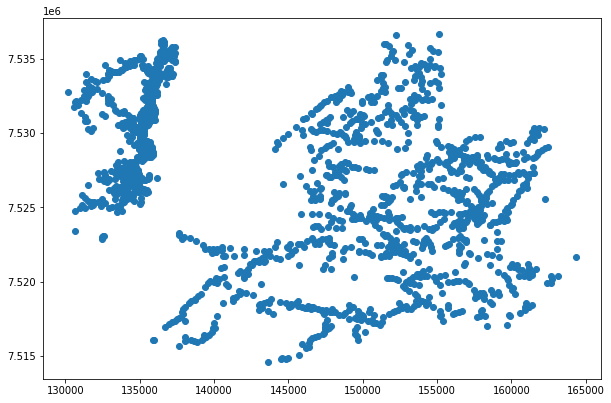

In [36]:
st = gpd.sjoin(
    join_area_cob[['geometry']], 
    copy_conj[['NOM','geometry']], 
    how='inner', 
    op='within', 
    lsuffix='untrs',
    rsuffix='conj')
st.head()
ax = st.plot(figsize=(10,10))

In [37]:
centro_urbano = Point(136050.57090952771250159, 7531008.69087591022253036)
group_ucbt_untrd_untrs['EUC_DIST_CENT'] = -1
for i,t in group_ucbt_untrd_untrs.iterrows():
    eud = group_ucbt_untrd_untrs.geometry_untrd[i].distance(centro_urbano)
    group_ucbt_untrd_untrs.EUC_DIST_CENT.loc[i] = eud
    
group_ucbt_untrd_untrs 

D:\Anaconda3\envs\diplo\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,UNI_TR_S,ARE_LOC,geometry_untrd,geometry_untrs,EUC_DIST_UNTRS,EUC_DIST_CENT
0,101415715,1,38.275000,14.000000,97.791667,372.0,27707534,0,POINT (143363.892 7518580.694),POINT (151650.771 7531499.639),15348.338990,14420.116797
1,103455355,1,8.310000,7.000000,91.333333,116.0,27707534,1,POINT (156545.369 7524131.090),POINT (151650.771 7531499.639),8846.050002,21618.004725
2,105138826,1,16.100000,12.000000,13.583333,35.0,27707534,0,POINT (159329.456 7522722.774),POINT (151650.771 7531499.639),11661.713633,24709.571305
3,106512676,1,17.240000,8.000000,84.833333,101.0,27707534,0,POINT (153744.945 7526685.029),POINT (151650.771 7531499.639),5250.336447,18214.964473
4,108015624,1,19.150000,9.000000,158.166667,180.0,27707534,0,POINT (154603.247 7526545.042),POINT (151650.771 7531499.639),5767.594872,19082.084868
...,...,...,...,...,...,...,...,...,...,...,...,...
3329,62005694,1,0.530000,2.000000,26.208333,83.0,80345241,1,POINT (133932.738 7527194.744),POINT (135820.103 7532486.422),5618.185482,4362.500497
3330,68553759,1,1.641667,2.625000,98.020833,3923.0,80345241,1,POINT (134190.805 7526273.478),POINT (135820.103 7532486.422),6423.027464,5087.333875
3331,71641214,1,1.210000,1.000000,160.950855,8415.0,80345241,1,POINT (134977.834 7526406.003),POINT (135820.103 7532486.422),6138.477770,4726.044503
3332,87219744,1,5.916341,3.560976,133.132114,8476.0,80345241,1,POINT (134897.455 7529229.454),POINT (135820.103 7532486.422),3385.132235,2120.226359


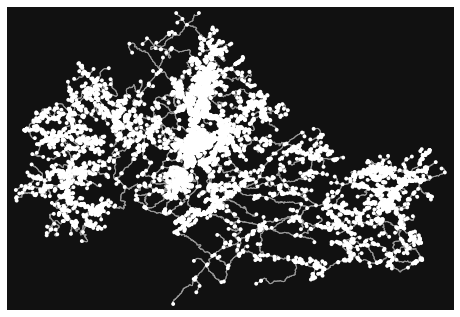

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [38]:
my_place = 'Nova Friburgo, Rio de Janeiro, Brazil'
G = ox.graph_from_place(my_place)
ox.plot_graph(G)

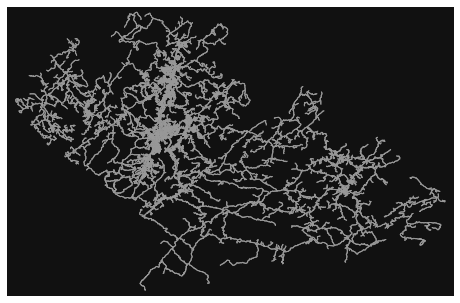

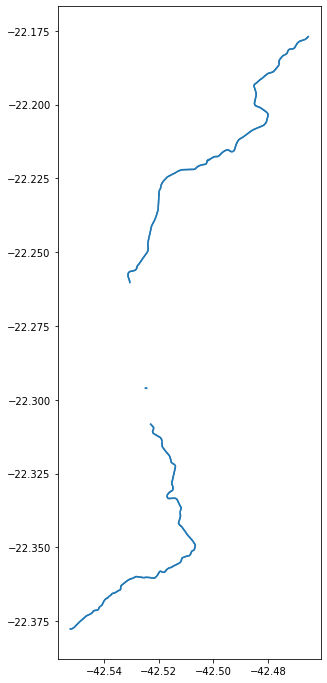

In [39]:
G.graph['crs']
dist = conj.dissolve(by='DIST')

G_conj = ox.graph_from_polygon(dist.to_crs(epsg=4326).iloc[0].geometry)
fig, ax = ox.plot_graph(G_conj, node_size=0)

nodes, edges = ox.graph_to_gdfs(G_conj)
edges.to_csv('edges_conj.csv')
edges[edges.name.str.contains('Rodovia').fillna(False)].plot(figsize=(12,12))
mask = (edges.highway.str.contains('trunk').fillna(False) | edges.highway.str.contains('primary').fillna(False))
mask_secondary = (edges.highway.str.contains('trunk').fillna(False) | edges.highway.str.contains('secondary').fillna(False))


<AxesSubplot:>

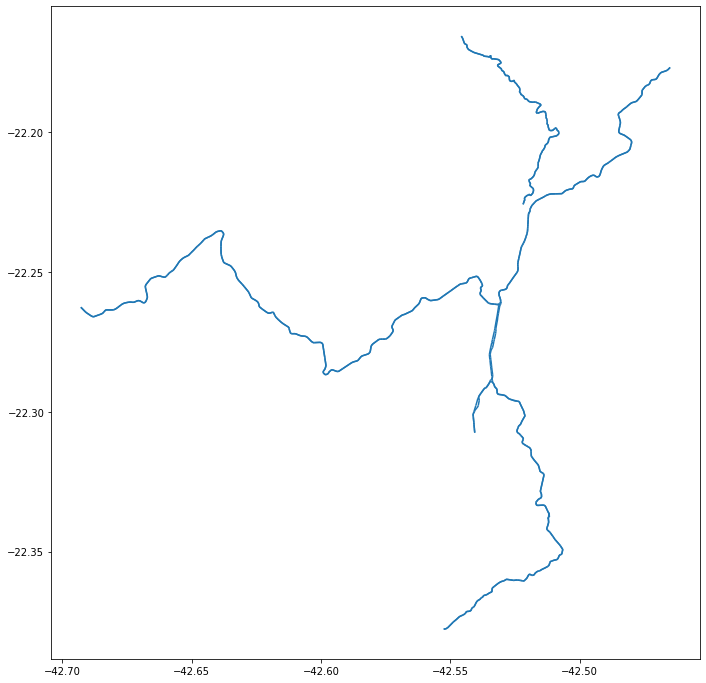

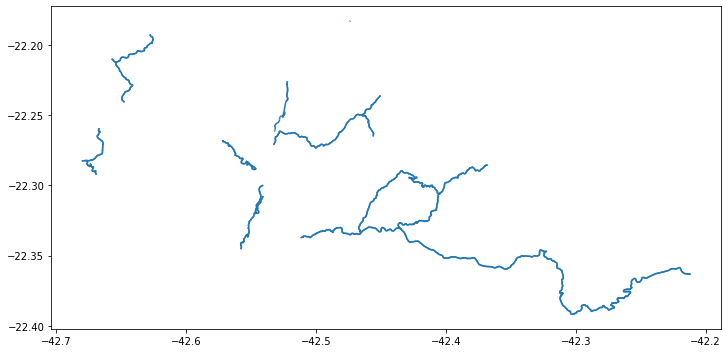

In [40]:
main_roads = edges[['geometry','length','name', 'ref']][mask]
secondary_roads = edges[['geometry','length','name', 'ref']][mask_secondary]

main_roads.plot(figsize=(12,12))
secondary_roads.plot(figsize=(12,12))

In [41]:
main_roads['dist'] = 6612
secondary_roads['dist'] = 6612

#CALLES PRINCIPALES
main_roads_comb = main_roads.dissolve(by='dist')
main_roads_comb.to_crs(epsg=31984, inplace= True)
#CALLES SECUNDARIAS
secondary_roads_comb = secondary_roads.dissolve(by='dist')
secondary_roads_comb.to_crs(epsg=31984, inplace= True)

group_ucbt_untrd_untrs['EUC_DIST_PRIMARY'] = -1
group_ucbt_untrd_untrs['EUC_DIST_SECONDARY'] = -1

for i,t in group_ucbt_untrd_untrs.iterrows():
    eud_main_roads = group_ucbt_untrd_untrs.geometry_untrd[i].distance(main_roads_comb.iloc[0].geometry)
    eud_secondary_roads = group_ucbt_untrd_untrs.geometry_untrd[i].distance(secondary_roads_comb.iloc[0].geometry)
    group_ucbt_untrd_untrs.EUC_DIST_PRIMARY.loc[i] = eud_main_roads
    group_ucbt_untrd_untrs.EUC_DIST_SECONDARY.loc[i] = eud_secondary_roads

group_ucbt_untrd_untrs

D:\Anaconda3\envs\diplo\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,UNI_TR_S,ARE_LOC,geometry_untrd,geometry_untrs,EUC_DIST_UNTRS,EUC_DIST_CENT,EUC_DIST_PRIMARY,EUC_DIST_SECONDARY
0,101415715,1,38.275000,14.000000,97.791667,372.0,27707534,0,POINT (143363.892 7518580.694),POINT (151650.771 7531499.639),15348.338990,14420.116797,7174.246302,7424.656820
1,103455355,1,8.310000,7.000000,91.333333,116.0,27707534,1,POINT (156545.369 7524131.090),POINT (151650.771 7531499.639),8846.050002,21618.004725,17768.331400,395.889376
2,105138826,1,16.100000,12.000000,13.583333,35.0,27707534,0,POINT (159329.456 7522722.774),POINT (151650.771 7531499.639),11661.713633,24709.571305,20611.624089,265.908068
3,106512676,1,17.240000,8.000000,84.833333,101.0,27707534,0,POINT (153744.945 7526685.029),POINT (151650.771 7531499.639),5250.336447,18214.964473,15155.618112,2825.851151
4,108015624,1,19.150000,9.000000,158.166667,180.0,27707534,0,POINT (154603.247 7526545.042),POINT (151650.771 7531499.639),5767.594872,19082.084868,15983.786567,2271.915950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,62005694,1,0.530000,2.000000,26.208333,83.0,80345241,1,POINT (133932.738 7527194.744),POINT (135820.103 7532486.422),5618.185482,4362.500497,2072.595399,372.619542
3330,68553759,1,1.641667,2.625000,98.020833,3923.0,80345241,1,POINT (134190.805 7526273.478),POINT (135820.103 7532486.422),6423.027464,5087.333875,2765.175831,135.015985
3331,71641214,1,1.210000,1.000000,160.950855,8415.0,80345241,1,POINT (134977.834 7526406.003),POINT (135820.103 7532486.422),6138.477770,4726.044503,2462.589748,920.239663
3332,87219744,1,5.916341,3.560976,133.132114,8476.0,80345241,1,POINT (134897.455 7529229.454),POINT (135820.103 7532486.422),3385.132235,2120.226359,223.587769,35.513025


In [42]:
group_ucbt_untrd_untrs.columns

Index(['UNI_TR_D', 'GRU_TAR', 'DIC', 'FIC', 'ENE_MED', 'ENE_MAX', 'UNI_TR_S',
       'ARE_LOC', 'geometry_untrd', 'geometry_untrs', 'EUC_DIST_UNTRS',
       'EUC_DIST_CENT', 'EUC_DIST_PRIMARY', 'EUC_DIST_SECONDARY'],
      dtype='object')

In [43]:
group_ucbt_untrd_untrs = group_ucbt_untrd_untrs.merge(DF,on='UNI_TR_D', how='left')
group_ucbt_untrd_untrs

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,UNI_TR_S,ARE_LOC,geometry_untrd,geometry_untrs,EUC_DIST_UNTRS,EUC_DIST_CENT,EUC_DIST_PRIMARY,EUC_DIST_SECONDARY,TIEMPO_MIN,DISTANCIA_KM
0,101415715,1,38.275000,14.000000,97.791667,372.0,27707534,0,POINT (143363.892 7518580.694),POINT (151650.771 7531499.639),15348.338990,14420.116797,7174.246302,7424.656820,0.000000,0.000
1,103455355,1,8.310000,7.000000,91.333333,116.0,27707534,1,POINT (156545.369 7524131.090),POINT (151650.771 7531499.639),8846.050002,21618.004725,17768.331400,395.889376,0.000000,0.000
2,105138826,1,16.100000,12.000000,13.583333,35.0,27707534,0,POINT (159329.456 7522722.774),POINT (151650.771 7531499.639),11661.713633,24709.571305,20611.624089,265.908068,51.116667,26.069
3,106512676,1,17.240000,8.000000,84.833333,101.0,27707534,0,POINT (153744.945 7526685.029),POINT (151650.771 7531499.639),5250.336447,18214.964473,15155.618112,2825.851151,61.683333,27.599
4,108015624,1,19.150000,9.000000,158.166667,180.0,27707534,0,POINT (154603.247 7526545.042),POINT (151650.771 7531499.639),5767.594872,19082.084868,15983.786567,2271.915950,58.983333,26.696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,62005694,1,0.530000,2.000000,26.208333,83.0,80345241,1,POINT (133932.738 7527194.744),POINT (135820.103 7532486.422),5618.185482,4362.500497,2072.595399,372.619542,14.283333,6.982
3330,68553759,1,1.641667,2.625000,98.020833,3923.0,80345241,1,POINT (134190.805 7526273.478),POINT (135820.103 7532486.422),6423.027464,5087.333875,2765.175831,135.015985,14.666667,7.440
3331,71641214,1,1.210000,1.000000,160.950855,8415.0,80345241,1,POINT (134977.834 7526406.003),POINT (135820.103 7532486.422),6138.477770,4726.044503,2462.589748,920.239663,12.400000,6.965
3332,87219744,1,5.916341,3.560976,133.132114,8476.0,80345241,1,POINT (134897.455 7529229.454),POINT (135820.103 7532486.422),3385.132235,2120.226359,223.587769,35.513025,8.500000,3.983


In [44]:
group_ucbt_untrd_untrs.to_csv("Dataset/group_ucbt_untrd_untrs_dist_v2.csv")

## [Opcional] Generación de variables con arboles de busqueda

8 - Cree variables que indique la cantidad de consumidores en radios de 25, 50 y 100 metros del transformador.

9 - Cree una variable indicando la distancia media de cada fila (cada untrd) a los 5 untrd mas cercanos.

10 - Usando OSMnx descargue los footprints de edificios disponibles, y cree una variable que indique la cantidad de edificios en un radio de 200 metros al transformador.

In [45]:
# Convertimos las coordenas a una matriz
ucbt_loc_array = [x.coords[0] for x in ucbt.geometry]
untrd_loc_array = [x.coords[0] for x in untrd.geometry]
tree = cKDTree(ucbt_loc_array)

In [185]:
group_ucbt_untrd_untrs['CONS_25M'] = 0
group_ucbt_untrd_untrs['CONS_50M'] = 0
group_ucbt_untrd_untrs['CONS_100M'] = 0

for i,t in group_ucbt_untrd_untrs.iterrows():
  untrd_loc_array = [x.coords[0] for x in [group_ucbt_untrd_untrs.geometry_untrd[i]]]
  radio = 25
  ucbt_25m = tree.query_ball_point(untrd_loc_array, radio)
  radio = 50
  ucbt_50m = tree.query_ball_point(untrd_loc_array, radio)
  radio = 100
  ucbt_100m = tree.query_ball_point(untrd_loc_array, radio)

  group_ucbt_untrd_untrs.CONS_25M.loc[i] = len(ucbt_25m[0])  
  group_ucbt_untrd_untrs.CONS_50M.loc[i] = len(ucbt_50m[0])  
  group_ucbt_untrd_untrs.CONS_100M.loc[i] = len(ucbt_100m[0])  

D:\Anaconda3\envs\diplo\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [186]:
group_ucbt_untrd_untrs[['UNI_TR_D','CONS_25M','CONS_50M','CONS_100M']].sample(5)

,UNI_TR_D,CONS_25M,CONS_50M,CONS_100M
776,26877063,1,1,1
3264,26880527,24,87,236
160,26876388,0,8,23
197,26876425,8,31,67
2439,26879008,0,1,3
